# EOD Price History Prediction
*This notebook is intended to predict price movements based on EOD closing prices. Work in progress.*

This notebook is largely based on code from this article:
https://towardsdatascience.com/multiple-stock-prediction-using-deep-learning-network-d19a7acd8551`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import datetime

# The cells below here only read symbols from the notebook that are similar to the one that we are trying to predict, given the the amount of data we have.

## For now, run the first import cell in the notebook, then work from here.

*In the example below, we're only going to look at stocks that have the same sector or industry id as FСEL*

In [2]:
# Choose what Symbol you would like to predict:
symbol = 'CTXR'     # change to whatever symbol in your dataframe you'd like to attempt to predict.
start_date = "2019-01-01"
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

In [3]:
conn = sqlite3.connect('stockPrediction_06072021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])
df

open_price  high_price   low_price  close_price  \
stock_symbol price_datetime                                                    
HTBX         2013-07-24      700.000000  713.299988  631.400024   669.900024   
             2013-07-25      654.500000  667.099976  632.099976   650.299988   
             2013-07-26      644.000000  649.599976  631.400024   649.599976   
             2013-07-29      640.500000  657.299988  630.700012   641.200012   
             2013-07-30      634.200012  663.599976  634.200012   655.200012   
...                                 ...         ...         ...          ...   
CCM          2021-06-07        3.320000    3.489900    3.400000     3.463300   
CHMJF        2021-06-07        0.071500    0.071500    0.067100     0.067100   
ESMC         2021-06-07        0.245000    0.248490    0.245000     0.245000   
ESSI         2021-06-07        0.015000    0.015000    0.015000     0.015000   
FIORF        2021-06-07        0.102600    0.108900    0.101000     0.101000   

                              volume  dividends stock_splits  
stock_symbol price_datetime                                   
HTBX         2013-07-24      15803.0        0.0          0.0  
             2013-07-25       2503.0        0.0          0.0  
             2013-07-26        549.0        0.0          0.0  
             2013-07-29         71.0        0.0          0.0  
             2013-07-30        276.0        0.0          0.0  
...                              ...        ...          ...  
CCM          2021-06-07       2127.0        0.0          0.0  
CHMJF        2021-06-07      16456.0        0.0            0  
ESMC         2021-06-07      15599.0        0.0          0.0  
ESSI         2021-06-07       2201.0        0.0          0.0  
FIORF        2021-06-07       1990.0        0.0          0.0  

[1400976 rows x 7 columns]

*Now, lets remove the index and reshape the data to prepare it for our model. In doing so, we're also going to convert the price_datetime column to datetime/timestamp objects prior to resetting our index.*

In [4]:
# reset the index
df = df.reset_index()

In [5]:
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

In [6]:
# check to make sure the data type is write
type(df['price_datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

*Next, we will reshape our data. We will make the price_datetime the index, and add columns for each symbol. After this, we can filter the dataframe based on date range.*

In [6]:
# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

In [8]:
df

open_price                                                     \
stock_symbol         ABEO  ABIO  ABUS  ACBM  ACER  ACHFF    ACST  ADIL  ADMA   
price_datetime                                                                 
1980-03-18            NaN   NaN   NaN   NaN   NaN    NaN     NaN   NaN   NaN   
1980-03-19            NaN   NaN   NaN   NaN   NaN    NaN     NaN   NaN   NaN   
1980-03-20            NaN   NaN   NaN   NaN   NaN    NaN     NaN   NaN   NaN   
1980-03-21            NaN   NaN   NaN   NaN   NaN    NaN     NaN   NaN   NaN   
1980-03-24            NaN   NaN   NaN   NaN   NaN    NaN     NaN   NaN   NaN   
...                   ...   ...   ...   ...   ...    ...     ...   ...   ...   
2021-05-20           1.50  3.34  2.72  2.85  2.80  1.095  0.5700  2.37  1.77   
2021-05-21           1.60  3.37  2.80  2.85  2.90  1.095  0.4900  2.52  1.78   
2021-05-24           1.57  3.34  2.75  2.85  2.90  1.040  0.5000  2.50  1.76   
2021-05-25           1.54  3.25  2.70  2.85  2.89  1.040  0.5048  2.51  1.71   
2021-05-26           1.54  3.25  2.68   NaN  2.89    NaN  0.5048  2.51  1.71   

                      ... stock_splits                                     \
stock_symbol    ADTX  ...         VTVT VYNE WIZP XBIO XCUR XERS XTLB ZIOP   
price_datetime        ...                                                   
1980-03-18       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1980-03-19       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1980-03-20       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1980-03-21       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1980-03-24       NaN  ...          NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...              ...  ...          ...  ...  ...  ...  ...  ...  ...  ...   
2021-05-20      2.34  ...            0  0.0  0.0  0.0    0    0  0.0    0   
2021-05-21      2.38  ...            0  0.0  0.0  0.0    0    0  0.0    0   
2021-05-24      2.40  ...            0  0.0  0.0  0.0    0    0  0.0    0   
2021-05-25      2.37  ...            0  0.0  0.0  0.0    0    0  0.0    0   
2021-05-26      2.37  ...            0  0.0  NaN  0.0    0    0  0.0    0   

                          
stock_symbol   ZIVO ZSAN  
price_datetime            
1980-03-18      NaN  NaN  
1980-03-19      NaN  NaN  
1980-03-20      NaN  NaN  
1980-03-21      NaN  NaN  
1980-03-24      NaN  NaN  
...             ...  ...  
2021-05-20        0  0.0  
2021-05-21        0  0.0  
2021-05-24        0  0.0  
2021-05-25        0  0.0  
2021-05-26        0  0.0  

[10387 rows x 1848 columns]

In [7]:
df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

In [9]:
df['close_price']

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACBM,ACER,ACHFF,ACRHF,ACRX,...,XTLB,XTNT,XXII,YCBD,ZCMD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-02,7.0300,5.94,0.07,0.1200,4.00,NaN,21.450001,0.948,NaN,2.480,...,1.76,2.25,2.67,3.150,NaN,2.2100,0.140,1.2500,2.340,3.72
2019-01-03,6.6200,6.12,0.10,0.1200,3.77,NaN,20.400000,0.952,NaN,2.600,...,1.74,2.09,2.61,3.220,NaN,2.1500,0.140,1.1600,2.410,3.67
2019-01-04,7.0200,6.84,0.10,0.1200,4.10,NaN,21.500000,0.952,NaN,2.740,...,1.90,2.20,2.76,3.270,NaN,2.2400,0.140,1.2400,2.640,4.00
2019-01-07,7.5100,6.84,0.09,0.1200,4.20,NaN,23.090000,0.952,NaN,2.840,...,1.72,2.25,2.84,3.260,NaN,2.2700,0.130,1.2500,2.720,4.00
2019-01-08,7.3100,6.66,0.09,0.1200,4.05,NaN,23.500000,0.952,NaN,2.740,...,2.12,2.24,2.85,3.240,NaN,2.1900,0.120,1.2500,2.770,4.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-20,1.5700,3.33,0.06,0.0700,2.78,2.85,2.890000,1.095,4.3200,1.280,...,3.58,1.47,4.54,3.020,1.7900,3.1200,0.130,0.7880,0.757,4.86
2021-05-21,1.6200,3.33,0.06,0.1200,2.74,2.85,2.890000,1.095,4.3300,1.270,...,3.49,1.51,4.55,3.060,1.8300,3.1500,0.130,0.8200,0.756,4.84
2021-05-24,1.5500,3.26,0.06,0.1200,2.70,2.85,2.860000,1.040,4.3150,1.290,...,3.64,1.43,4.67,3.100,1.8400,3.0500,0.130,0.7900,0.730,4.68


In [8]:
# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

In [9]:
# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

In [12]:
close_df

stock_symbol,ABEO,ABIO,ABMC,ABUS,ACER,ACRX,ACST,ADIL,ADMA,ADMP,...,XERS,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-02,7.0300,5.94,0.07,4.00,21.450001,2.480,0.9000,6.50,2.6200,2.3900,...,17.50,1.76,2.25,2.67,3.150,2.2100,0.140,1.2500,2.340,3.72
2019-01-03,6.6200,6.12,0.10,3.77,20.400000,2.600,0.8700,6.75,2.8100,2.3400,...,16.83,1.74,2.09,2.61,3.220,2.1500,0.140,1.1600,2.410,3.67
2019-01-04,7.0200,6.84,0.10,4.10,21.500000,2.740,0.9000,6.40,2.9500,2.4500,...,17.50,1.90,2.20,2.76,3.270,2.2400,0.140,1.2400,2.640,4.00
2019-01-07,7.5100,6.84,0.09,4.20,23.090000,2.840,0.9200,6.00,3.1400,2.4300,...,17.84,1.72,2.25,2.84,3.260,2.2700,0.130,1.2500,2.720,4.00
2019-01-08,7.3100,6.66,0.09,4.05,23.500000,2.740,0.9200,6.29,3.4100,2.5000,...,18.74,2.12,2.24,2.85,3.240,2.1900,0.120,1.2500,2.770,4.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-20,1.5700,3.33,0.06,2.78,2.890000,1.280,0.5000,2.53,1.7600,0.7700,...,3.50,3.58,1.47,4.54,3.020,3.1200,0.130,0.7880,0.757,4.86
2021-05-21,1.6200,3.33,0.06,2.74,2.890000,1.270,0.5100,2.52,1.7600,0.8000,...,3.47,3.49,1.51,4.55,3.060,3.1500,0.130,0.8200,0.756,4.84
2021-05-24,1.5500,3.26,0.06,2.70,2.860000,1.290,0.5000,2.51,1.7100,0.7400,...,3.27,3.64,1.43,4.67,3.100,3.0500,0.130,0.7900,0.730,4.68


In [10]:
# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)
close_df

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XERS,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-02,7.030,5.9400,0.0700,0.12000,4.00,21.450001,0.9480,2.480,0.9000,0.140,...,17.50,1.7600,2.250,2.670,3.1500,2.2100,0.140,1.2500,2.3400,3.7200
2019-01-03,6.620,6.1200,0.1000,0.12000,3.77,20.400000,0.9520,2.600,0.8700,0.120,...,16.83,1.7400,2.090,2.610,3.2200,2.1500,0.140,1.1600,2.4100,3.6700
2019-01-04,7.020,6.8400,0.1000,0.12000,4.10,21.500000,0.9520,2.740,0.9000,0.120,...,17.50,1.9000,2.200,2.760,3.2700,2.2400,0.140,1.2400,2.6400,4.0000
2019-01-07,7.510,6.8400,0.0900,0.12000,4.20,23.090000,0.9520,2.840,0.9200,0.120,...,17.84,1.7200,2.250,2.840,3.2600,2.2700,0.130,1.2500,2.7200,4.0000
2019-01-08,7.310,6.6600,0.0900,0.12000,4.05,23.500000,0.9520,2.740,0.9200,0.120,...,18.74,2.1200,2.240,2.850,3.2400,2.1900,0.120,1.2500,2.7700,4.1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,1.710,3.4900,0.0636,0.07920,2.86,2.960000,1.1180,1.430,0.5071,0.365,...,3.00,3.5400,1.450,4.600,2.9300,3.0700,4.255,0.8239,0.8025,5.0700
2021-06-02,1.745,3.5690,0.0645,0.11490,3.02,2.910000,1.1400,1.440,0.5290,0.365,...,3.22,3.5500,1.488,4.650,3.1550,3.0400,4.145,0.8379,0.8006,5.2800
2021-06-03,1.825,3.7000,0.0631,0.07609,2.90,2.881000,1.1400,1.445,0.5373,0.365,...,3.92,3.5242,1.660,4.645,3.1500,3.1400,4.290,1.0050,0.8069,5.1819


<AxesSubplot:xlabel='price_datetime'>

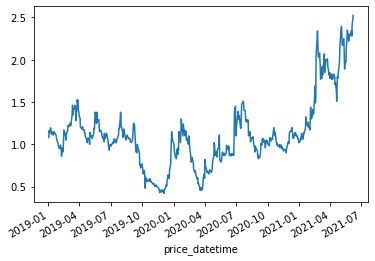

In [12]:
close_df[symbol].plot()

## Creating a ML model

### Split the test/training data

In [11]:
# splitting test/training data

# close_df = close_df.reset_index()

data_size = len(close_df)

# using a 90/10 train/test split
training_data = close_df.iloc[:(int(data_size * .7))]
test_data = close_df.iloc[(int(data_size * .7)):]

In [17]:
training_data

stock_symbol,ABEO,ABIO,ABUS,ACER,ACST,ADIL,ADMA,ADXS,AEZS,AGE,...,VSTM,VTGN,VTVT,VYNE,XBIO,XCUR,XERS,XTLB,ZIOP,ZSAN
price_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-02,7.03,5.94,4.00,21.450001,0.90,6.50,2.620,4.425,3.03,3.000,...,3.61,1.59,2.82,19.320000,20.400000,3.450,17.50,1.76,2.21,2.34
2019-01-03,6.62,6.12,3.77,20.400000,0.87,6.75,2.810,4.050,3.08,3.110,...,3.51,1.56,2.58,18.639999,21.480000,3.270,16.83,1.74,2.15,2.41
2019-01-04,7.02,6.84,4.10,21.500000,0.90,6.40,2.950,4.185,3.41,3.540,...,3.77,1.56,2.59,20.120001,21.240000,3.300,17.50,1.90,2.24,2.64
2019-01-07,7.51,6.84,4.20,23.090000,0.92,6.00,3.140,6.180,3.49,3.750,...,3.98,1.67,2.37,20.760000,23.639999,3.250,17.84,1.72,2.27,2.72
2019-01-08,7.31,6.66,4.05,23.500000,0.92,6.29,3.410,5.250,3.35,3.870,...,4.04,1.66,3.12,20.320000,23.760000,3.060,18.74,2.12,2.19,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28,2.24,4.99,3.03,2.540000,0.71,1.35,2.745,0.531,0.47,0.950,...,1.32,0.69,2.13,5.920000,1.030000,2.115,4.25,1.70,2.74,1.61
2020-08-31,2.35,5.48,2.91,2.650000,0.24,1.38,2.550,0.496,0.47,0.883,...,1.26,0.70,2.08,6.120000,1.040000,1.990,4.71,1.70,2.81,1.63
2020-09-01,2.35,5.21,2.76,2.640000,0.22,1.50,2.400,0.468,0.44,0.860,...,1.24,0.68,2.00,5.800000,1.005000,1.960,4.81,1.83,2.63,1.53


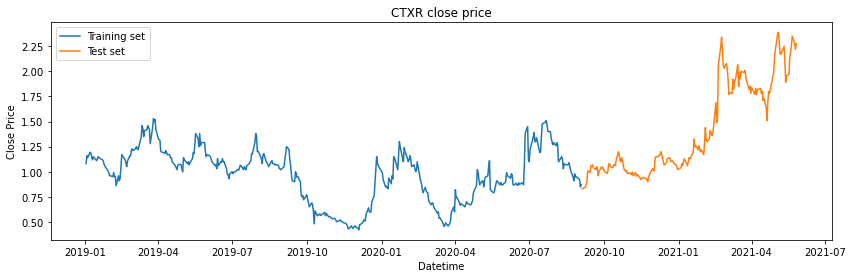

In [16]:
# visualize train/test dataset to ensure it is accurate
plt.figure(figsize=(14,4))
plt.plot(training_data[symbol])
plt.plot(test_data[symbol])
plt.ylabel('Close Price')
plt.xlabel('Datetime')
plt.legend(["Training set", "Test set"])
plt.title(f"{symbol} close price")
plt.show()

In [17]:
training_data.isna().sum().sum()

0

## Normalization

*Using MinMaxScaler, normalize data on a 0-1 scale using the training data.*
*The minmax_single symbol will be the one we are trying to predict. In this case, the one we are trying to predict is FCEL*

In [12]:
# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()
training_data_predicted

,CTXR
price_datetime,
2019-01-02,1.080
2019-01-03,1.160
2019-01-04,1.140
2019-01-07,1.195
2019-01-08,1.185
...,...
2020-09-04,0.830
2020-09-08,0.845
2020-09-09,0.875


In [13]:
minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)
train_scaled

,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE,CTXR
0,0.813411,0.214328,0.008850,0.148649,0.587242,0.789330,0.643077,0.542587,0.261993,0.060606,...,0.502924,0.425587,0.921397,0.415091,0.061508,0.7,1.000000,0.342908,0.065079,0.594595
1,0.753644,0.224985,0.035398,0.148649,0.544090,0.748442,0.649231,0.580442,0.250923,0.000000,...,0.491228,0.383812,0.895196,0.426402,0.049603,0.7,0.921191,0.355476,0.061111,0.666667
2,0.811953,0.267614,0.035398,0.148649,0.606004,0.791277,0.649231,0.624606,0.261993,0.000000,...,0.584795,0.412533,0.960699,0.434481,0.067460,0.7,0.991243,0.396768,0.087302,0.648649
3,0.883382,0.267614,0.026549,0.148649,0.624765,0.853193,0.649231,0.656151,0.269373,0.000000,...,0.479532,0.425587,0.995633,0.432865,0.073413,0.6,1.000000,0.411131,0.087302,0.698198
4,0.854227,0.256957,0.026549,0.148649,0.596623,0.869159,0.649231,0.624606,0.269373,0.000000,...,0.713450,0.422977,1.000000,0.429633,0.057540,0.5,1.000000,0.420108,0.096825,0.689189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.077259,0.123742,0.132743,0.229730,0.294559,0.049065,0.746154,0.123028,0.003690,0.484849,...,0.497076,0.046997,0.017904,0.290677,0.109127,0.4,0.005254,0.166966,0.057937,0.369369
424,0.091837,0.120782,0.141593,0.229730,0.300188,0.044003,0.723077,0.110410,0.007380,0.484849,...,0.608187,0.041775,0.011790,0.290677,0.111111,0.3,0.009632,0.170557,0.056349,0.382883
425,0.084548,0.126702,0.141593,0.229730,0.313321,0.044782,0.723077,0.123028,0.003690,0.363636,...,0.766082,0.041775,0.000000,0.263209,0.134921,0.4,0.002627,0.179533,0.051587,0.409910
426,0.086006,0.132623,0.150442,0.229730,0.288931,0.042835,0.723077,0.104101,0.003690,0.454546,...,0.684211,0.054830,0.015284,0.263209,0.123016,0.3,0.001751,0.195691,0.048413,0.427928


## Shaping data for LSTM

In [14]:
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

In [15]:
# check shapes
X_train.shape, y_train.shape

((368, 60, 395), (368,))

## Build the LSTM network
*I think for now that I may only try to do a single layer, to speed up development of the project.*

**Be sure that the last layer of the network has return_sequences set to False.**

In [16]:
# LSTM architecture
regressor = tf.keras.Sequential()

# First layer, w/ dropout regularization
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.2))

# Second
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

# Third
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Fourth
regressor.add(tf.keras.layers.LSTM(units=20))
regressor.add(tf.keras.layers.Dropout(0.5))

# Output layer
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Fit to Training set
# fit to training set
num_features = len(training_data.columns)
progress = 1
for i in training_data.columns:
    print("Fitting to", i)
    print("Training feature", progress, "of", num_features)
    regressor.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    progress += 1

Fitting to ABEO
Training feature 1 of 393
Fitting to ABIO
Training feature 2 of 393
Fitting to ABMC
Training feature 3 of 393
Fitting to ABUS
Training feature 4 of 393
Fitting to ACER
Training feature 5 of 393
Fitting to ACRX
Training feature 6 of 393
Fitting to ACST
Training feature 7 of 393
Fitting to ADIL
Training feature 8 of 393
Fitting to ADMA
Training feature 9 of 393
Fitting to ADMP
Training feature 10 of 393
Fitting to ADMS
Training feature 11 of 393
Fitting to ADMT
Training feature 12 of 393
Fitting to ADXS
Training feature 13 of 393
Fitting to AEMD
Training feature 14 of 393
Fitting to AEZS
Training feature 15 of 393
Fitting to AGE
Training feature 16 of 393
Fitting to AGEN
Training feature 17 of 393
Fitting to AGRX
Training feature 18 of 393
Fitting to AGTC
Training feature 19 of 393
Fitting to AHPI
Training feature 20 of 393
Fitting to AIKI
Training feature 21 of 393
Fitting to AIM
Training feature 22 of 393
Fitting to AKBA
Training feature 23 of 393
Fitting to AKTX
Traini

In [16]:
# set a model name and save it
# cell is optional
regressor.save('model_06022021_100epochs01')

NameError: name 'regressor' is not defined

In [22]:
# load a model later
regressor = tf.keras.models.load_model('model_20210606_153456')

## Predictions
*1. Merge training/testing set on 0 axis.
2. Set the n_lags as time steps.
3. Transform the new data set.
4. Reshape the new data set.*

In [23]:
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

Shape of test data: (244, 395)


In [24]:
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index

ValueError: in user code:

    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, None, 412), found shape=(None, 60, 395)


In [20]:
predicted_price[f'{symbol}_predicted']

NameError: name 'predicted_price' is not defined

In [21]:
# Visualization
from sklearn.metrics import mean_squared_error
plt.figure(figsize=(14,5))
#mse = mean_squared_error(y_test, predicted_price)
plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
# plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
plt.title(f'{symbol} Closing Price Prediction')
plt.xlabel("Time")
plt.ylabel('Price USD')
plt.legend()

NameError: name 'predicted_price' is not defined

In [21]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data[symbol], predicted_price[f'{symbol}_predicted'])
print('MSE:', mse)

MSE: 0.9092953102156633


In [28]:
# test cell
df['close_price'].mean()

stock_symbol
ABEO    3.331455
ABIO    5.490826
ABUS    2.732314
ACBM    3.071516
ACER    6.854959
          ...   
XERS    6.987983
XTLB    2.069289
ZIOP    3.686644
ZIVO    0.120709
ZSAN    1.724281
Length: 264, dtype: float64

In [41]:
test_data['SPPI']

price_datetime
2020-09-04    3.98
2020-09-08    4.00
2020-09-09    4.06
2020-09-10    3.95
2020-09-11    3.93
              ... 
2021-05-20    3.41
2021-05-21    3.36
2021-05-24    3.22
2021-05-25    3.25
2021-05-26    3.24
Name: SPPI, Length: 182, dtype: float64

In [25]:
# this cell is to change the predicted symbol
symbol = "CTXR"
# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()
training_data_predicted

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

# this section may not be necessary
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# this may also not be necessary

total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

# this part is absolutely necessary
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index

Shape of test data: (244, 395)


ValueError: in user code:

    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\james\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, None, 412), found shape=(None, 60, 395)


## Test some symbols and get the MSE
*The cell below predicts values for a list of symbols, saving plots of the predictions and a file containing the MSE values for those predicted symbols*

In [15]:
import os
from sklearn.metrics import mean_squared_error
test_symbols = ["CTXR", "IBIO", "MNKD", "IMGN", "ATOS", "SPPI"]

current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

directory = f"test_plots_{current_datetime}"
parent_dir = r"C:\Users\james\Dropbox\Box Sync\code\stockPrediction"

path = os.path.join(parent_dir, directory)
os.mkdir(path)

mse_values = pd.Series()

for symbol in test_symbols:
    # First, create a singular dataframe from the symbol you would like to predict vaues for
    training_data_predicted = training_data[symbol]
    training_data_predicted = training_data_predicted.to_frame()
    training_data_predicted

    minmax = MinMaxScaler(feature_range=(0,1))
    minmax_single = MinMaxScaler(feature_range=(0,1))

    # Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
    training_data = training_data.drop(columns=symbol)
    train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

    columns = [i for i in training_data.columns]
    columns.append(symbol)

    # I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
    training_data[symbol] = training_data_predicted[symbol]

    train_scaled = pd.DataFrame(train_scaled, columns=columns)

    # this section may not be necessary
    train_scaled = train_scaled.values
    n_lags = int(60) # not sure why hard 60
    X_train = []
    y_train = []
    for i in range(n_lags, train_scaled.shape[0]):
        X_train.append(train_scaled[i-n_lags:i])
        y_train.append(train_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

    # this may also not be necessary

    total_data = pd.concat((training_data, test_data), axis=0)
    inputs = total_data[len(total_data) - len(test_data) - 60:]
    # inputs = data[len(data) - len(test_data) - 60:]

    predicted_input = inputs[symbol].to_frame()
    inputs = inputs.drop(columns=symbol)

    test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
    print('Shape of test data:', test_scaled.shape)

    # shaping test data from neural network
    X_test = []
    y_test = []
    for i in range(60, test_scaled.shape[0]):
        X_test.append(test_scaled[i-n_lags:i])
        y_test.append(test_scaled[i,0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

    # this part is absolutely necessary
    predicted_price = regressor.predict(X_test)
    predicted_price = minmax_single.inverse_transform(predicted_price)
    predicted_price = pd.DataFrame(predicted_price)
    predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
    predicted_price = predicted_price.round(decimals=2)
    predicted_price.index = test_data.index

    # plot
    plt.figure(figsize=(14,5))
    #mse = mean_squared_error(y_test, predicted_price)
    plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
    plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
    plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
    # plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
    plt.title(f'{symbol} Closing Price Prediction')
    plt.xlabel("Time")
    plt.ylabel('Price USD')
    plt.legend()
    plt.savefig(f"{path}/{symbol}_{current_datetime}")

    mse = mean_squared_error(test_data[symbol], predicted_price[f'{symbol}_predicted'])
    mse_values[symbol] = mse

mse_values.to_csv(f"{path}/{symbol}_{current_datetime}_mse.csv")

<ipython-input-15-7d109c986540>:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mse_values = pd.Series()
Shape of test data: (83, 412)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Runs everything at once
*The cell below runs everything at once, and outputs information like the cell above, effectively automating the entire process.*

Fitting to ABEO
Training feature 1 of 412
Fitting to ABIO
Training feature 2 of 412
Fitting to ABMC
Training feature 3 of 412
Fitting to ABUS
Training feature 4 of 412
Fitting to ACER
Training feature 5 of 412
Fitting to ACRX
Training feature 6 of 412
Fitting to ACST
Training feature 7 of 412
Fitting to ADIL
Training feature 8 of 412
Fitting to ADMA
Training feature 9 of 412
Fitting to ADMP
Training feature 10 of 412
Fitting to ADMS
Training feature 11 of 412
Fitting to ADMT
Training feature 12 of 412
Fitting to ADXS
Training feature 13 of 412
Fitting to AEMD
Training feature 14 of 412
Fitting to AEZS
Training feature 15 of 412
Fitting to AGE
Training feature 16 of 412
Fitting to AGEN
Training feature 17 of 412
Fitting to AGRX
Training feature 18 of 412
Fitting to AGTC
Training feature 19 of 412
Fitting to AHPI
Training feature 20 of 412
Fitting to AIKI
Training feature 21 of 412
Fitting to AIM
Training feature 22 of 412
Fitting to AKBA
Training feature 23 of 412
Fitting to AKTX
Traini

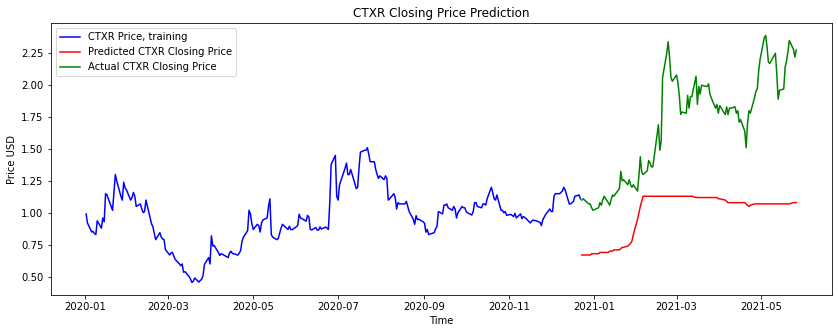

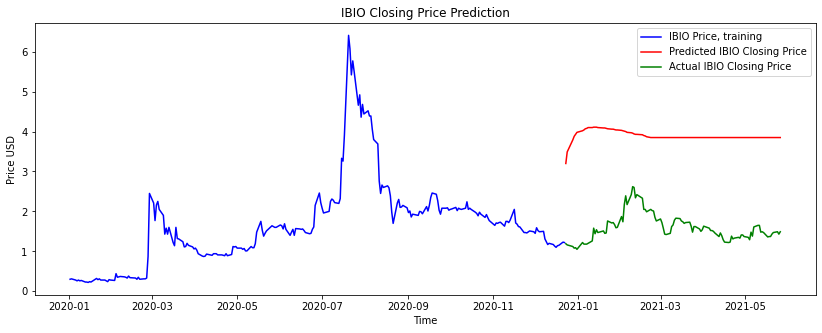

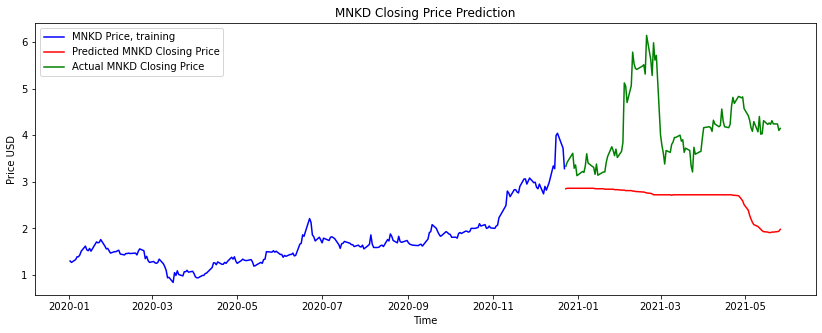

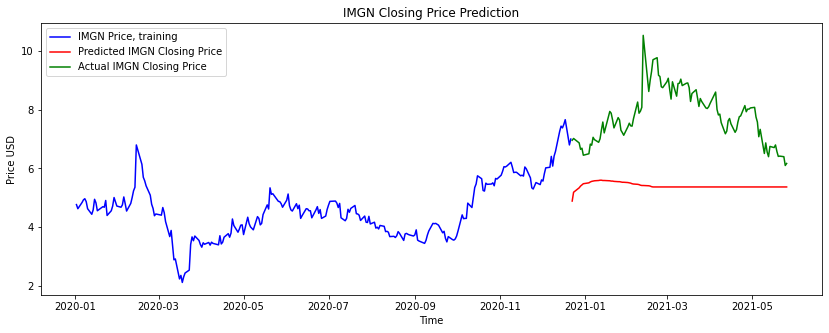

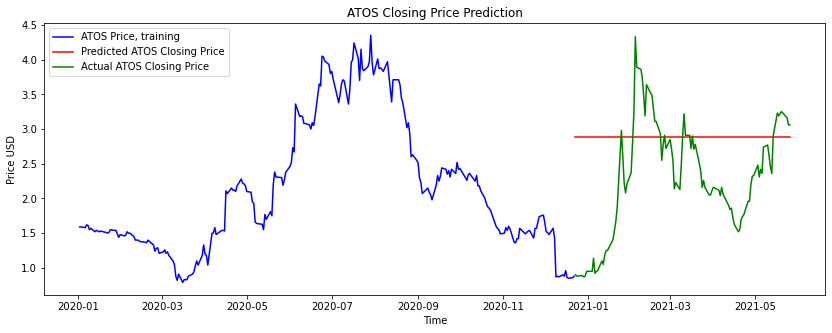

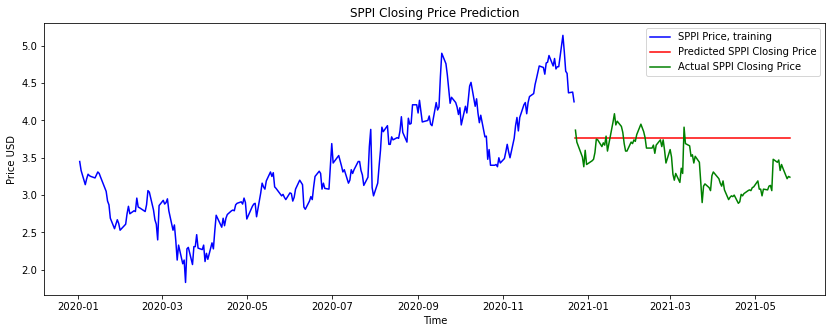

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import datetime
import os
from sklearn.metrics import mean_squared_error
test_symbols = ["CTXR", "IBIO", "MNKD", "IMGN", "ATOS", "SPPI"]
model_settings = {'epochs': 100, 'batch_size': 2, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100}

# Choose what Symbol you would like to predict:
symbol = 'CTXR'     # change to whatever symbol in your dataframe you'd like to attempt to predict.
start_date = "2020-01-01"
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_settings['start_date'] = start_date
model_settings['end_date'] = current_date

# next cell
conn = sqlite3.connect('stockPrediction_05262021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# next
# reset the index
df = df.reset_index()

# next
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)

# splitting test/training data
data_size = len(close_df)

# using a 90/10 train/test split
training_data = close_df.iloc[:(int(data_size * model_settings['train_test_ratio']))]
test_data = close_df.iloc[(int(data_size * model_settings['train_test_ratio'])):]

# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# TRAINING THE MODEL

# LSTM architecture
regressor = tf.keras.Sequential()

# First layer, w/ dropout regularization
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.2))

# Second
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

# Third
regressor.add(tf.keras.layers.LSTM(units=model_settings['units'], return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.5))

# Fourth
regressor.add(tf.keras.layers.LSTM(units=model_settings['units']))
regressor.add(tf.keras.layers.Dropout(0.5))

# Output layer
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Fit to Training set
# fit to training set
num_features = len(training_data.columns)
progress = 1
for i in training_data.columns:
    print("Fitting to", i)
    print("Training feature", progress, "of", num_features)
    regressor.fit(X_train, y_train, epochs=model_settings['epochs'], batch_size=model_settings['batch_size'], verbose=0)
    progress += 1

print("Saving Model...")
regressor.save(f"model_{current_datetime}")
print("Model Saved.")

# next part may not be necessary:
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
# print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index     # end of possibly not necessary code

# now onto the test

directory = f"test_plots_{current_datetime}"
parent_dir = r"C:\Users\james\Dropbox\Box Sync\code\stockPrediction"

path = os.path.join(parent_dir, directory)
os.mkdir(path)

mse_values = pd.Series()
model_settings_pd = pd.Series(model_settings)
model_settings_pd.to_csv(f"{path}/{current_datetime}_model_settings.csv")

for symbol in test_symbols:
    # First, create a singular dataframe from the symbol you would like to predict vaues for
    training_data_predicted = training_data[symbol]
    training_data_predicted = training_data_predicted.to_frame()

    minmax = MinMaxScaler(feature_range=(0,1))
    minmax_single = MinMaxScaler(feature_range=(0,1))

    # Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
    training_data = training_data.drop(columns=symbol)
    train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

    columns = [i for i in training_data.columns]
    columns.append(symbol)

    # I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
    training_data[symbol] = training_data_predicted[symbol]

    train_scaled = pd.DataFrame(train_scaled, columns=columns)

    # this section may not be necessary
    train_scaled = train_scaled.values
    n_lags = int(60) # not sure why hard 60
    X_train = []
    y_train = []
    for i in range(n_lags, train_scaled.shape[0]):
        X_train.append(train_scaled[i-n_lags:i])
        y_train.append(train_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

    # this may also not be necessary

    total_data = pd.concat((training_data, test_data), axis=0)
    inputs = total_data[len(total_data) - len(test_data) - 60:]
    # inputs = data[len(data) - len(test_data) - 60:]

    predicted_input = inputs[symbol].to_frame()
    inputs = inputs.drop(columns=symbol)

    test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
    print('Shape of test data:', test_scaled.shape)

    # shaping test data from neural network
    X_test = []
    y_test = []
    for i in range(60, test_scaled.shape[0]):
        X_test.append(test_scaled[i-n_lags:i])
        y_test.append(test_scaled[i,0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

    # this part is absolutely necessary
    predicted_price = regressor.predict(X_test)
    predicted_price = minmax_single.inverse_transform(predicted_price)
    predicted_price = pd.DataFrame(predicted_price)
    predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
    predicted_price = predicted_price.round(decimals=2)
    predicted_price.index = test_data.index

    # plot
    plt.figure(figsize=(14,5))
    #mse = mean_squared_error(y_test, predicted_price)
    plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
    plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
    plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
    # plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
    plt.title(f'{symbol} Closing Price Prediction')
    plt.xlabel("Time")
    plt.ylabel('Price USD')
    plt.legend()
    plt.savefig(f"{path}/{symbol}_{current_datetime}")

    mse = mean_squared_error(test_data[symbol], predicted_price[f'{symbol}_predicted'])
    mse_values[symbol] = mse

mse_values.to_csv(f"{path}/{current_datetime}_mse.csv")

## Cells below are used to update the model with new data

*This is assuming you ran the cell above to train a model, and are able to reload it.*

*First, it is necessary to figure out what the last date was we trained the model on was. After that, we can decide what new values to feed to the model.*

*The cell begins like the first, only this time we have a new database that we are getting additional values from.*

*First, we're going to load the older database, to find the last day we trained on.*

*After that, we'll reload the dataframe from the newer database, then train on that new data.*

*Then we will save an updated version of the model.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import datetime
import os
from sklearn.metrics import mean_squared_error
test_symbols = ["CTXR", "IBIO", "MNKD", "IMGN", "ATOS", "SPPI"]
model_settings = {'epochs': 100, 'batch_size': 4, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100}

# Choose what Symbol you would like to predict:
symbol = 'CTXR'     # change to whatever symbol in your dataframe you'd like to attempt to predict.
start_date = "2020-01-01"
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_settings['start_date'] = start_date
model_settings['end_date'] = current_date

# next cell
# this is the OLD database as of 6/8/21
conn = sqlite3.connect('stockPrediction_05262021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# next
# reset the index
df = df.reset_index()

# next
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)

# splitting test/training data
data_size = len(close_df)

# using a 90/10 train/test split
training_data = close_df.iloc[:(int(data_size * model_settings['train_test_ratio']))]
test_data = close_df.iloc[(int(data_size * model_settings['train_test_ratio'])):]

last_date = training_data.index[-1]

*Now we reload the data from the new database, and then filter out all of the rows that were in the training data.*

In [2]:
conn = sqlite3.connect('stockPrediction_06072021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# next
# reset the index
df = df.reset_index()

# next
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)

In [3]:
close_df = close_df[close_df.index > last_date]

In [4]:
training_data = close_df

# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))


In [5]:
# load model, fit new data, save new model

# set the current datetime
current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# load model
regressor = regressor = tf.keras.models.load_model('model_20210606_153456')

# fit to training set
num_features = len(training_data.columns)
progress = 1
for i in training_data.columns:
    print("Fitting to", i)
    print("Training feature", progress, "of", num_features)
    regressor.fit(X_train, y_train, epochs=model_settings['epochs'], batch_size=model_settings['batch_size'], verbose=0)
    progress += 1

print("Saving Model...")
regressor.save(f"model_{current_datetime}")
print("Model Saved.")

Fitting to ABEO
Training feature 1 of 412
Fitting to ABIO
Training feature 2 of 412
Fitting to ABMC
Training feature 3 of 412
Fitting to ABMT
Training feature 4 of 412
Fitting to ABUS
Training feature 5 of 412
Fitting to ACER
Training feature 6 of 412
Fitting to ACHFF
Training feature 7 of 412
Fitting to ACRX
Training feature 8 of 412
Fitting to ACST
Training feature 9 of 412
Fitting to ACUR
Training feature 10 of 412
Fitting to ADIL
Training feature 11 of 412
Fitting to ADMA
Training feature 12 of 412
Fitting to ADMP
Training feature 13 of 412
Fitting to ADMS
Training feature 14 of 412
Fitting to ADMT
Training feature 15 of 412
Fitting to ADXS
Training feature 16 of 412
Fitting to AEMD
Training feature 17 of 412
Fitting to AEZS
Training feature 18 of 412
Fitting to AGE
Training feature 19 of 412
Fitting to AGEN
Training feature 20 of 412
Fitting to AGRX
Training feature 21 of 412
Fitting to AGTC
Training feature 22 of 412
Fitting to AHPI
Training feature 23 of 412
Fitting to AIKI
Trai

## Below here, we are loading the newly updated model and attempting to make predictions on symbols that we feed to it.

*First, the imports*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import datetime
import os
from sklearn.metrics import mean_squared_error

*Next, we'll load our datasets and clean them up like we did before. We'll be trying to predict the same symbols movement over the next two weeks.*

*This will go as far as loading the dataset and removing outliers.*

In [2]:
test_symbols = ["CTXR", "IBIO", "MNKD", "IMGN", "ATOS", "SPPI"]
model_settings = {'epochs': 100, 'batch_size': 4, 'train_test_ratio': 1, 'hidden_layers': 3, 'units': 100}

# Choose what Symbol you would like to predict:
symbol = 'CTXR'     # change to whatever symbol in your dataframe you'd like to attempt to predict.
start_date = "2020-01-01"
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_settings['start_date'] = start_date
model_settings['end_date'] = current_date

# next cell
# this is the OLD database as of 6/8/21
conn = sqlite3.connect('stockPrediction_06072021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{symbol}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# next
# reset the index
df = df.reset_index()

# next
# convert to datetime
df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

# reshape
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[start_date:current_date]  # date range from 2019-01-01 to 2021-05-31

# set a threshold of how many np.nan you are willing to work with
close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

# forward fill in np.nan values in columns not previously dropped.
close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)

*Prepare the data for predictions.*

*Not sure if everything here is necessary.*

In [3]:
# splitting test/training data
data_size = len(close_df)

training_data = close_df    # easiest way to do this for now
test_data = close_df

# calc two weeks from todays date;llllllllll54hg8=[-]
today = datetime.datetime.now()
future = datetime.timedelta(days=14)
two_weeks_from_date = today + future

test_data = test_data.reset_index()

future_dates = []

# for now, -2 b/c of my data
for date in range (-2, 30):
    future = datetime.timedelta(days=date)
    future = today + future
    if future.weekday() in [5,6]:
        continue
    future = future.strftime('%Y-%m-%d')
    future = pd.to_datetime(future, format='%Y-%m-%d')
    future_dates.append({'price_datetime': future})

test_data = test_data.append(future_dates, ignore_index=True)

test_data = test_data.set_index('price_datetime')

# this value may need to change, i'm not sure
test_data = test_data[-24:-1]

test_data.tail(30)

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2021-06-04,1.705,3.6451,0.0620,0.0800,3.01,2.99,1.1174,1.49,0.5503,0.36,...,1.76,3.35,1.61,4.695,3.0098,3.0529,4.35,0.9110,0.8187,5.18
2021-06-07,1.740,3.6400,0.0735,0.0665,3.27,2.97,1.1486,1.55,0.5715,0.36,...,1.76,3.50,1.63,5.240,3.2400,3.0000,4.25,0.9667,0.9148,5.31
2021-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
regressor = tf.keras.models.load_model('model_20210608_203045')

<ipython-input-8-3fdf077e36da>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mse_values = pd.Series()
Shape of test data: (83, 412)
Shape of test data: (83, 412)
Shape of test data: (83, 412)
Shape of test data: (83, 412)
Shape of test data: (83, 412)
Shape of test data: (83, 412)


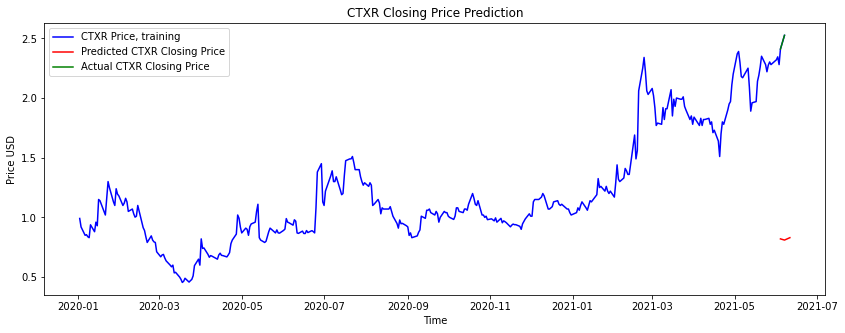

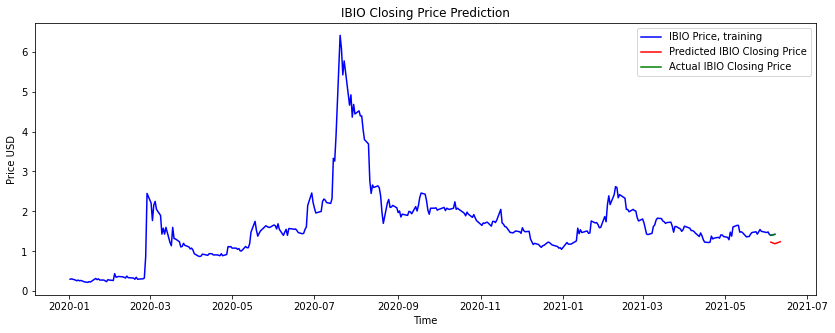

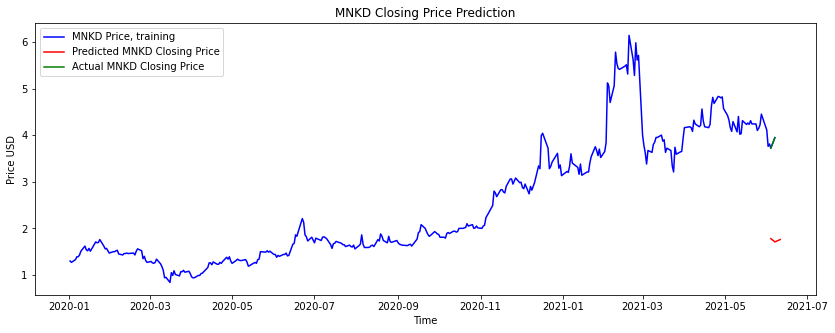

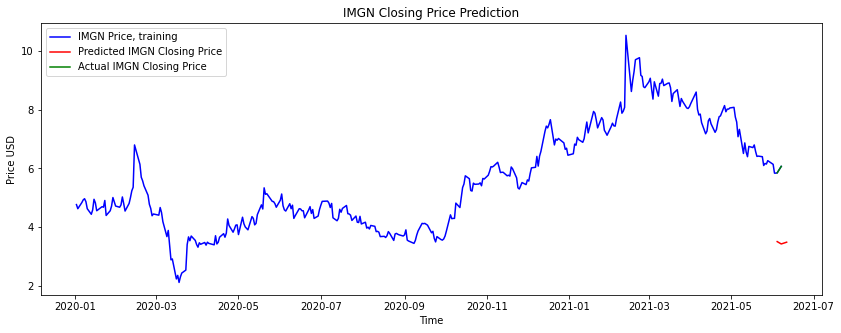

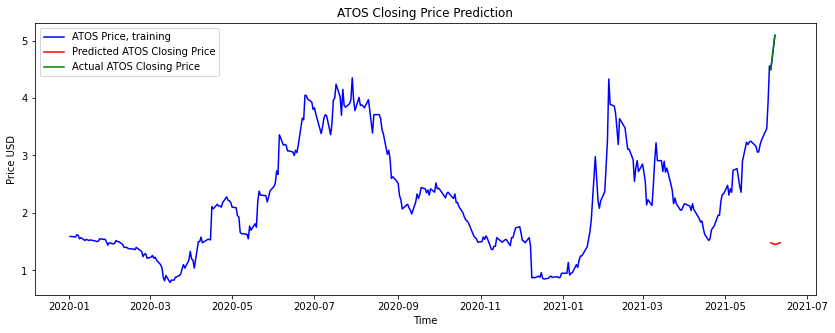

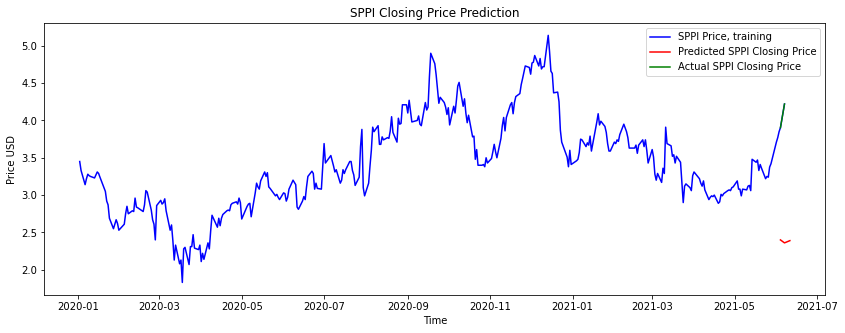

In [8]:
mse_values = pd.Series()
for symbol in test_symbols:
    # First, create a singular dataframe from the symbol you would like to predict vaues for
    training_data_predicted = training_data[symbol]
    training_data_predicted = training_data_predicted.to_frame()
    training_data_predicted

    minmax = MinMaxScaler(feature_range=(0,1))
    minmax_single = MinMaxScaler(feature_range=(0,1))

    # Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
    training_data = training_data.drop(columns=symbol)
    train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

    columns = [i for i in training_data.columns]
    columns.append(symbol)

    # I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
    training_data[symbol] = training_data_predicted[symbol]

    train_scaled = pd.DataFrame(train_scaled, columns=columns)

    # this section may not be necessary
    train_scaled = train_scaled.values
    n_lags = int(60) # not sure why hard 60
    X_train = []
    y_train = []
    for i in range(n_lags, train_scaled.shape[0]):
        X_train.append(train_scaled[i-n_lags:i])
        y_train.append(train_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

    # this may also not be necessary

    total_data = pd.concat((training_data, test_data), axis=0)
    inputs = total_data[len(total_data) - len(test_data) - 60:]
    # inputs = data[len(data) - len(test_data) - 60:]

    predicted_input = inputs[symbol].to_frame()
    inputs = inputs.drop(columns=symbol)

    test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
    print('Shape of test data:', test_scaled.shape)

    # shaping test data from neural network
    X_test = []
    y_test = []
    for i in range(60, test_scaled.shape[0]):
        X_test.append(test_scaled[i-n_lags:i])
        y_test.append(test_scaled[i,0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

    # this part is absolutely necessary
    predicted_price = regressor.predict(X_test)
    predicted_price = minmax_single.inverse_transform(predicted_price)
    predicted_price = pd.DataFrame(predicted_price)
    predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
    predicted_price = predicted_price.round(decimals=2)
    predicted_price.index = test_data.index

    # plot
    plt.figure(figsize=(14,5))
    #mse = mean_squared_error(y_test, predicted_price)
    plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
    plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
    plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
    # plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
    plt.title(f'{symbol} Closing Price Prediction')
    plt.xlabel("Time")
    plt.ylabel('Price USD')
    plt.legend()
    # plt.savefig(f"{path}/{symbol}_{current_datetime}")

    #mse = mean_squared_error(test_data[symbol], predicted_price[f'{symbol}_predicted'])
    #mse_values[symbol] = mse
#mse_values

In [9]:
X_test.shape

(23, 60, 412)

<ipython-input-14-7b4488a846e5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mse_values = pd.Series()
Shape of test data: (83, 412)
Shape of test data: (83, 412)
Shape of test data: (83, 412)
Shape of test data: (83, 412)
Shape of test data: (83, 412)
Shape of test data: (83, 412)


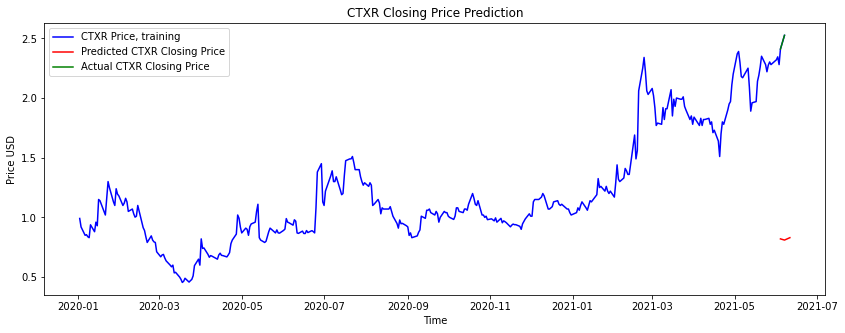

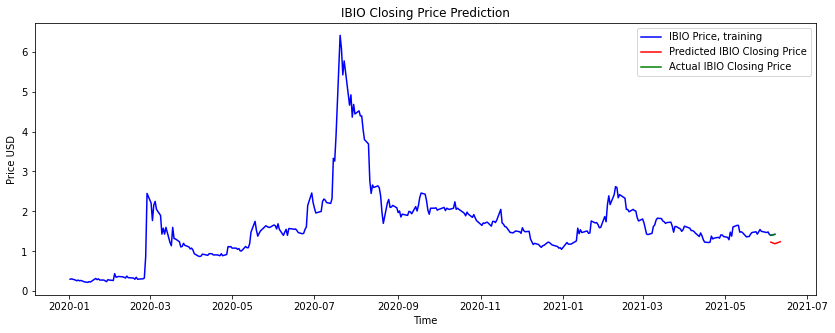

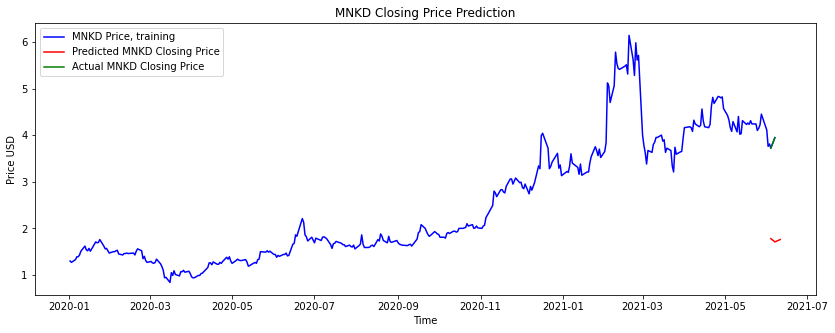

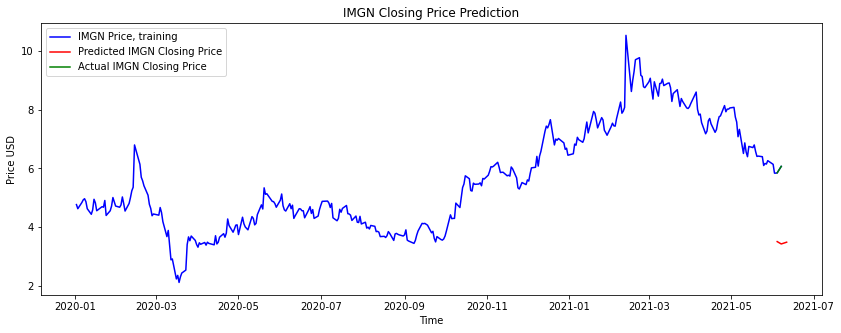

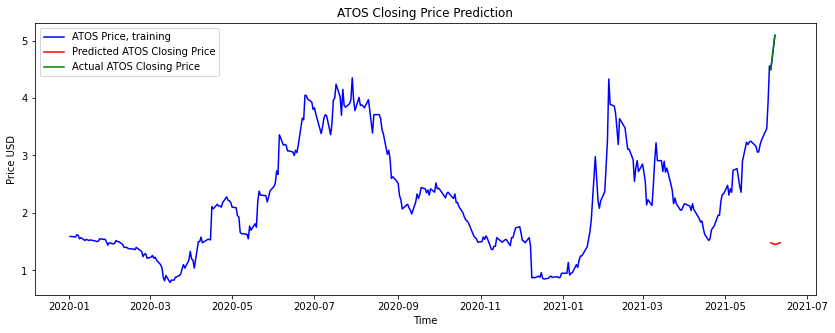

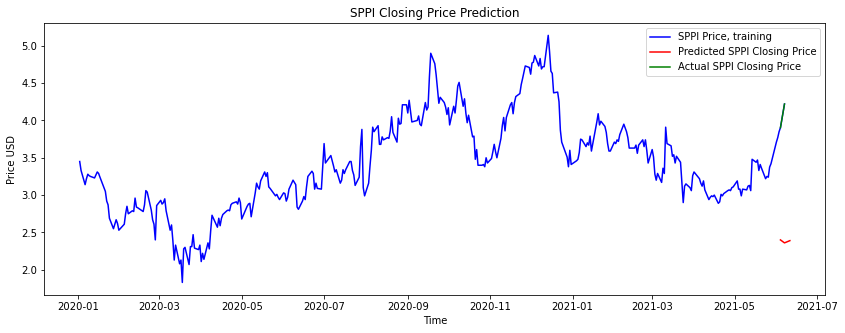

In [14]:
# working to increase the # of predictions
mse_values = pd.Series()
for symbol in test_symbols:
    # First, create a singular dataframe from the symbol you would like to predict vaues for
    training_data_predicted = training_data[symbol]
    training_data_predicted = training_data_predicted.to_frame()
    training_data_predicted

    minmax = MinMaxScaler(feature_range=(0,1))
    minmax_single = MinMaxScaler(feature_range=(0,1))

    # Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
    training_data = training_data.drop(columns=symbol)
    train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

    columns = [i for i in training_data.columns]
    columns.append(symbol)

    # I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
    training_data[symbol] = training_data_predicted[symbol]

    train_scaled = pd.DataFrame(train_scaled, columns=columns)

    # this section may not be necessary
    train_scaled = train_scaled.values
    n_lags = int(60) # not sure why hard 60
    X_train = []
    y_train = []
    for i in range(n_lags, train_scaled.shape[0]):
        X_train.append(train_scaled[i-n_lags:i])
        y_train.append(train_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

    # this may also not be necessary

    total_data = pd.concat((training_data, test_data), axis=0)
    inputs = total_data[len(total_data) - len(test_data) - 60:]
    # inputs = data[len(data) - len(test_data) - 60:]

    predicted_input = inputs[symbol].to_frame()
    inputs = inputs.drop(columns=symbol)

    test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
    print('Shape of test data:', test_scaled.shape)

    # shaping test data from neural network
    X_test = []
    y_test = []
    for i in range(60, test_scaled.shape[0]):
        X_test.append(test_scaled[i-n_lags:i])
        y_test.append(test_scaled[i,0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))
    '''X_test = close_df[symbol].values
    X_test = X_test.reshape(())'''

    # this part is absolutely necessary
    predicted_price = regressor.predict(X_test)
    predicted_price = minmax_single.inverse_transform(predicted_price)
    predicted_price = pd.DataFrame(predicted_price)
    predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
    predicted_price = predicted_price.round(decimals=2)
    predicted_price.index = test_data.index

    # plot
    plt.figure(figsize=(14,5))
    #mse = mean_squared_error(y_test, predicted_price)
    plt.plot(training_data[symbol], color = 'blue', label=f'{symbol} Price, training')
    plt.plot(predicted_price[f'{symbol}_predicted'], color = 'red', label= f'Predicted {symbol} Closing Price')
    plt.plot(test_data[symbol], color = 'green', label = f'Actual {symbol} Closing Price')
    # plt.title("FCEL Closing PRice Prediction w/ MSE {:10:4f}".format(mse))
    plt.title(f'{symbol} Closing Price Prediction')
    plt.xlabel("Time")
    plt.ylabel('Price USD')
    plt.legend()
    # plt.savefig(f"{path}/{symbol}_{current_datetime}")

    #mse = mean_squared_error(test_data[symbol], predicted_price[f'{symbol}_predicted'])
    #mse_values[symbol] = mse
#mse_values

In [6]:
predicted_price.iloc[-30:-1]

,SPPI_predicted
price_datetime,
2021-06-04,2.40
2021-06-07,2.36
2021-06-11,2.39
2021-06-14,NaN
2021-06-15,NaN
2021-06-16,NaN
2021-06-17,NaN
2021-06-18,NaN
2021-06-21,NaN


In [5]:
# trying to debug...

# First, create a singular dataframe from the symbol you would like to predict vaues for
training_data_predicted = training_data[symbol]
training_data_predicted = training_data_predicted.to_frame()
training_data_predicted

minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# Replace FCEL w/ the symbol you'd like to predict, also apply this elsewhere
training_data = training_data.drop(columns=symbol)
train_scaled = np.concatenate([minmax.fit_transform(training_data.values), minmax_single.fit_transform(training_data_predicted.values)], axis=1)

columns = [i for i in training_data.columns]
columns.append(symbol)

# I am apparently missing all of the predicted symbol when later merging my data, maybe this will help?
training_data[symbol] = training_data_predicted[symbol]

train_scaled = pd.DataFrame(train_scaled, columns=columns)

# this section may not be necessary
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# this may also not be necessary

total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

predicted_input = inputs[symbol].to_frame()
inputs = inputs.drop(columns=symbol)

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])



Shape of test data: (83, 412)


In [6]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

# this part is absolutely necessary
for i in test_data:
    predicted_price = regressor.predict(X_test)
    predicted_price = minmax_single.inverse_transform(predicted_price)
    predicted_price = pd.DataFrame(predicted_price)
    predicted_price.rename(columns = {0: f'{symbol}_predicted'}, inplace=True)
    predicted_price = predicted_price.round(decimals=2)
    predicted_price.index = test_data.index

    total_data = pd.concat((training_data, predicted_price), axis=0)
    inputs = total_data[len(total_data) - len(predicted_price) - 60:]
    # inputs = data[len(data) - len(test_data) - 60:]

    predicted_input = inputs[symbol].to_frame()
    inputs = inputs.drop(columns=symbol)

    test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
    print('Shape of test data:', test_scaled.shape)

    # shaping test data from neural network
    X_test = []
    y_test = []
    for i in range(60, test_scaled.shape[0]):
        X_test.append(test_scaled[i-n_lags:i])
        y_test.append(test_scaled[i,0])



ValueError: operands could not be broadcast together with shapes (83,412) (411,) (83,412) 

In [37]:
predicted_price

,SPPI_predicted
price_datetime,
2021-06-08,2.44
2021-06-09,NaN
2021-06-10,NaN
2021-06-11,NaN
2021-06-14,NaN
2021-06-15,NaN
2021-06-16,NaN
2021-06-17,NaN
2021-06-18,NaN


In [10]:
test_data

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2021-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
len(test_data.columns), len(training_data.columns)

(412, 412)

In [9]:
for i in test_data.columns:
    if i not in training_data.columns:
        print(i)

In [13]:
# new method to try to predict values
from sklearn.datasets import make_regression

#test_data['CTXR_predicted'] = np.nan

test_data_predicted = test_data[symbol]
test_data = test_data.drop(symbol, axis=1)

Xnew, a = make_regression(n_samples=3, n_features=len(test_data.columns), noise=0.1, random_state=1)
Xnew = minmax.transform(Xnew)

# make prediction
ynew = regressor.predict(len(Xnew))

for i in range(len(Xnew)):
    print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))

IndexError: list index out of range